## The Divine Comedy Analysis

In [2]:
import numpy as np
import pandas as pd
import spacy
import ast
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import   wordnet as wn
from nltk.corpus import  stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from collections import Counter , defaultdict
from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import time
import multiprocessing
import re

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sns

### Data

Divine Comedy is a long Italian narrative poem composed of three *cantiche* : Inferno, Purgatorio and Paradiso. 
Inferno is divided into 34 *cantos*, while Purgatorio and Paradiso into 33, each poem is in turn written in tercets. 

For my analysis I have used 3 txt files exported on xlsx, subdiving each text in single verses. English version of the texts, translated by Henry Wadsworth Longfellow,  are publicly available on ***gutenberg.org***.


### Preprocessing 

Txt files have been cleaned (removed empty lines and the cantos' number) before preprocessing. 
Then we start the preprocessing by converting all the characters to lowercase, in order to avoid problems due to the capital letters. After that, we start the tokenization process, in which all the entries are broken into set of words. Lastly, we remove all the stopwords, non-alphanumeric characters and perform word lemmatization. The whole process has been carried out for each dataset, separately, in order to  perform a more easily analysis on the different poems.
Later, the three datasets will be grouped together to allow the comparison between the three texts.
In terms of length, the final Dataframes are equal to the ones obtained before the preprocessing, however the texts have been modified to contain only the explanatory content.

#### Inferno

In [2]:
#Delete empty lines and cantos' number in the txt file

#with open('/Users/leonardoyang/Desktop/3060994/Inferno_txt/Inferno.txt') as infile, open('/Users/leonardoyang/Desktop/3060994/Inferno_txt/Inferno_fin.txt', 'w') as outfile:
#    for line in infile:
#        if not (line.strip()): continue          # skip the empty line
#        if line.startswith('Inferno: Canto ') == True : continue  # skip canto's number
#        outfile.write(line)

In [ ]:
#Create the Dataframe for Inferno
nlp = spacy.load("en_core_web_sm")
Inferno_before = pd.read_excel('/Users/leonardoyang/Desktop/3060994/Inferno_txt/Inferno_fin.xlsx')
Inferno = pd.read_excel('/Users/leonardoyang/Desktop/3060994/Inferno_txt/Inferno_fin.xlsx')

In [ ]:
#Lower case
Inferno['Text'] = [entry.lower() for entry in Inferno['Text']]
# Tokenization 
Inferno['Text'] = [word_tokenize(entry) for entry in Inferno['Text']]

# Remove stopwords, non-alphanumeric and perfom Word Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun, verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(Inferno['Text']):
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():        # Check for Stopwords and consider only alphabets
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
            # The final processed set of words for each iteration will be stored in 'Final_words'
            
    Inferno.loc[index,'Text'] = str(Final_words)

In [5]:
#Create a column with lists of tokens
corpus = Inferno['Text'].tolist()
Inferno_list = []
for x in corpus:
    Inferno_list.append(ast.literal_eval(x))
Inferno['Tokens'] = Inferno_list

In [6]:
#Create a column with all the instances
instances_list = [' '.join(x) for x in Inferno_list]
Inferno['Instances'] = instances_list

Inferno['Text'] = 'Inferno'
Inferno = Inferno[['Text', 'Tokens', 'Instances']] 

In [7]:
Inferno_before.info()
Inferno_before.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4720 entries, 0 to 4719
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    4720 non-null   object
dtypes: object(1)
memory usage: 37.0+ KB


,Text
4715,And without care of having any rest
4716,"We mounted up, he first and I the second,"
4717,Till I beheld through a round aperture
4718,Some of the beauteous things that Heaven dot...
4719,Thence we came forth to rebehold the stars.


In [8]:
Inferno.info()
Inferno.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4720 entries, 0 to 4719
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       4720 non-null   object
 1   Tokens     4720 non-null   object
 2   Instances  4720 non-null   object
dtypes: object(3)
memory usage: 110.8+ KB


,Text,Tokens,Instances
4715,Inferno,"[without, care, rest]",without care rest
4716,Inferno,"[mount, first, second]",mount first second
4717,Inferno,"[till, behold, round, aperture]",till behold round aperture
4718,Inferno,"[beauteous, thing, heaven, doth, bear]",beauteous thing heaven doth bear
4719,Inferno,"[thence, come, forth, rebehold, star]",thence come forth rebehold star


### Repeat preprocessing for Purgatorio and Paradiso
#### Purgatorio 

In [9]:
#Delete empty lines and cantos' number in the txt file
#with open('/Users/leonardoyang/Desktop/3060994/Purgatorio_txt/Purgatorio.txt') as infile, open('/Users/leonardoyang/Desktop/3060994/Purgatorio_txt/Purgatorio_fin.txt', 'w') as outfile:
#    for line in infile:
#        if not (line.strip()): continue          # skip the empty line
#        if line.startswith('Purgatorio: Canto ') == True : continue
#        outfile.write(line)

In [10]:
#Create the Dataframe
Purgatorio_before = pd.read_excel('/Users/leonardoyang/Desktop/3060994/Purgatorio_txt/Purgatorio_fin.xlsx')
Purgatorio = pd.read_excel('/Users/leonardoyang/Desktop/3060994/Purgatorio_txt/Purgatorio_fin.xlsx')

In [11]:
Purgatorio['Text'] = [entry.lower() for entry in Purgatorio['Text']]

Purgatorio['Text'] = [word_tokenize(entry) for entry in Purgatorio['Text']]

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(Purgatorio['Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    Purgatorio.loc[index,'Text'] = str(Final_words)

In [12]:
corpus = Purgatorio['Text'].tolist()
Purgatorio_list = []

for x in corpus:
    Purgatorio_list.append(ast.literal_eval(x))
    
Purgatorio['Tokens'] = Purgatorio_list

instances_list = [' '.join(x) for x in Purgatorio_list]
Purgatorio['Instances'] = instances_list

Purgatorio['Text'] = 'Purgatorio'

In [13]:
Purgatorio = Purgatorio[['Text', 'Tokens', 'Instances']] 

In [14]:
Purgatorio_before.info()
Purgatorio_before.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4763 entries, 0 to 4762
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    4763 non-null   object
dtypes: object(1)
memory usage: 37.3+ KB


,Text
4758,The curb of art no farther lets me go.
4759,From the most holy water I returned
4760,"Regenerate, in the manner of new trees"
4761,"That are renewed with a new foliage,"
4762,Pure and disposed to mount unto the stars.


In [15]:
Purgatorio.info()
Purgatorio.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4763 entries, 0 to 4762
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       4763 non-null   object
 1   Tokens     4763 non-null   object
 2   Instances  4763 non-null   object
dtypes: object(3)
memory usage: 111.8+ KB


,Text,Tokens,Instances
4758,Purgatorio,"[curb, art, farther, let, go]",curb art farther let go
4759,Purgatorio,"[holy, water, return]",holy water return
4760,Purgatorio,"[regenerate, manner, new, tree]",regenerate manner new tree
4761,Purgatorio,"[renew, new, foliage]",renew new foliage
4762,Purgatorio,"[pure, dispose, mount, unto, star]",pure dispose mount unto star


#### Paradiso  

In [16]:
#Delete empty lines and cantos' number in the txt file
#with open('/Users/leonardoyang/Desktop/3060994/Paradiso_txt/Paradiso.txt') as infile, open('/Users/leonardoyang/Desktop/3060994/Paradiso_txt/Paradiso_fin.txt', 'w') as outfile:
#    for line in infile:
#        if not (line.strip()): continue          # skip the empty line
#        if line.startswith('Paradiso: Canto ') == True : continue
#        outfile.write(line)

In [1]:
#Create the Dataframe
Paradiso_before = pd.read_excel('/Users/leonardoyang/Desktop/3060994/Paradiso_txt/Paradiso_fin.xlsx')
Paradiso = pd.read_excel('/Users/leonardoyang/Desktop/3060994/Paradiso_txt/Paradiso_fin.xlsx')


NameError: name 'pd' is not defined

In [18]:
Paradiso['Text'] = [entry.lower() for entry in Paradiso['Text']]

Paradiso['Text'] = [word_tokenize(entry) for entry in Paradiso['Text']]

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(Paradiso['Text']):
    
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()

    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    
    Paradiso.loc[index,'Text'] = str(Final_words)

In [19]:
corpus = Paradiso['Text'].tolist()
Paradiso_list = []
for x in corpus:
    Paradiso_list.append(ast.literal_eval(x))
    
Paradiso['Tokens'] = Paradiso_list

instances_list = [' '.join(x) for x in Paradiso_list]
Paradiso['Instances'] = instances_list

Paradiso['Text'] = 'Paradiso'

In [20]:
Paradiso = Paradiso[['Text', 'Tokens', 'Instances']]

In [21]:
Paradiso_before.info()
Paradiso_before.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4758 entries, 0 to 4757
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    4758 non-null   object
dtypes: object(1)
memory usage: 37.3+ KB


,Text
4753,"A flash of lightning, wherein came its wish."
4754,Here vigour failed the lofty fantasy:
4755,"But now was turning my desire and will,"
4756,"Even as a wheel that equally is moved,"
4757,The Love which moves the sun and the other stars.


In [22]:
Paradiso.info()
Paradiso.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4758 entries, 0 to 4757
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       4758 non-null   object
 1   Tokens     4758 non-null   object
 2   Instances  4758 non-null   object
dtypes: object(3)
memory usage: 111.6+ KB


,Text,Tokens,Instances
4753,Paradiso,"[flash, lightning, wherein, come, wish]",flash lightning wherein come wish
4754,Paradiso,"[vigour, fail, lofty, fantasy]",vigour fail lofty fantasy
4755,Paradiso,"[turn, desire]",turn desire
4756,Paradiso,"[even, wheel, equally, move]",even wheel equally move
4757,Paradiso,"[love, move, sun, star]",love move sun star


In [23]:
#Create a Dataset for the Divine Comedy
Divine_comedy = pd.concat([Inferno, Purgatorio, Paradiso], ignore_index=True)
Divine_comedy.info()
Divine_comedy.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14241 entries, 0 to 14240
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       14241 non-null  object
 1   Tokens     14241 non-null  object
 2   Instances  14241 non-null  object
dtypes: object(3)
memory usage: 333.9+ KB


,Text,Tokens,Instances
14236,Paradiso,"[flash, lightning, wherein, come, wish]",flash lightning wherein come wish
14237,Paradiso,"[vigour, fail, lofty, fantasy]",vigour fail lofty fantasy
14238,Paradiso,"[turn, desire]",turn desire
14239,Paradiso,"[even, wheel, equally, move]",even wheel equally move
14240,Paradiso,"[love, move, sun, star]",love move sun star


### Research Question and Analysis

The research question we are going to investigate is how the semantic fields evolve during the path of Dante and whether there are significant differences among the three cantiche, or if the poems, even though set in different places, show the same characteristics in terms of contents. This is why, besides a comprehensive analysis of the most important terms in the texts, we will focus on the topic analysis, to reveal differences/analogies in their distribution.

##### I) Word embeddings
Use Word2vec in order to find most similar words. 

In [24]:
#List of the Tokens
token_list_inf = Inferno['Tokens'].to_list()
token_list_pur = Purgatorio['Tokens'].to_list()
token_list_par = Paradiso['Tokens'].to_list()

In [25]:
# Initialize the model for Inferno
w2v_model_inf = Word2Vec(size=100, # The size of 100 gives the best results
                     window=10, # The window of 10 has been chosen due to the length of each doc
                     iter=200, 
                     negative=5,
                     min_count=10, # Since the text is not very long, the minimum count is quite low
                     sample=0.0001,
                     workers=-1, 
                     hs=0
)
# build the vocabulary
w2v_model_inf.build_vocab(token_list_inf)
# train the model
w2v_model_inf.train(token_list_inf, total_examples=w2v_model_inf.corpus_count, epochs=w2v_model_inf.epochs)

(0, 0)

In [26]:
# Initialize the model for Purgatorio
w2v_model_pur = Word2Vec(size=100, # The size of 100 gives the best results
                     window=10, 
                     iter=200, 
                     negative=5,
                     min_count=10, # Since the text is not very long, the minimum count is quite low
                     sample=0.0001,
                     workers=-1, 
                     hs=0
)
# build the vocabulary
w2v_model_pur.build_vocab(token_list_pur)
# train the model
w2v_model_pur.train(token_list_pur, total_examples=w2v_model_pur.corpus_count, epochs=w2v_model_pur.epochs)

(0, 0)

In [27]:
# Initialize the model for Paradiso
w2v_model_par = Word2Vec(size=100, # The size of 100 gives the best results
                     window=10,
                     iter=200, 
                     negative=5,
                     min_count=10, # Since the text is not very long, the minimum count is quite low
                     sample=0.0001,
                     workers=-1, 
                     hs=0
)
# build the vocabulary
w2v_model_par.build_vocab(token_list_par)
# train the model
w2v_model_par.train(token_list_par, total_examples=w2v_model_par.corpus_count, epochs=w2v_model_par.epochs)

(0, 0)

In [28]:
w2v_model_inf.wv.most_similar(['god'])

[('remain', 0.293743371963501),
 ('death', 0.24466176331043243),
 ('return', 0.24301011860370636),
 ('never', 0.23985378444194794),
 ('land', 0.23163610696792603),
 ('could', 0.2273453176021576),
 ('whose', 0.22263488173484802),
 ('spirit', 0.21110133826732635),
 ('lamentation', 0.20258232951164246),
 ('moment', 0.1828371286392212)]

In [29]:
w2v_model_pur.wv.most_similar(['god'])

[('remain', 0.293743371963501),
 ('lady', 0.2461252212524414),
 ('death', 0.24466176331043243),
 ('return', 0.24301011860370636),
 ('never', 0.23985378444194794),
 ('plant', 0.2341896891593933),
 ('land', 0.23163610696792603),
 ('could', 0.2273453176021576),
 ('whose', 0.22263488173484802),
 ('spirit', 0.21110133826732635)]

In [30]:
w2v_model_par.wv.most_similar(['god'])

[('remain', 0.293743371963501),
 ('till', 0.2581956088542938),
 ('lady', 0.2461252212524414),
 ('death', 0.24466176331043243),
 ('return', 0.24301011860370636),
 ('never', 0.23985378444194794),
 ('could', 0.2273453176021576),
 ('whose', 0.22263488173484802),
 ('spirit', 0.21110133826732635),
 ('angel', 0.20924562215805054)]

In [31]:
w2v_model_inf.wv.most_similar(['love'])

[('cause', 0.22506646811962128),
 ('last', 0.22312119603157043),
 ('leader', 0.21624314785003662),
 ('feel', 0.2095017284154892),
 ('burn', 0.20785029232501984),
 ('cruel', 0.2064540833234787),
 ('along', 0.19980186223983765),
 ('show', 0.19795212149620056),
 ('shade', 0.19284871220588684),
 ('deep', 0.19232752919197083)]

In [32]:
w2v_model_pur.wv.most_similar(['love'])

[('cause', 0.22506646811962128),
 ('leader', 0.21624314785003662),
 ('virgilius', 0.21437925100326538),
 ('feel', 0.2095017284154892),
 ('along', 0.19980186223983765),
 ('show', 0.19795212149620056),
 ('shade', 0.19284871220588684),
 ('advance', 0.19161996245384216),
 ('sit', 0.19147542119026184),
 ('haste', 0.19098715484142303)]

In [33]:
w2v_model_par.wv.most_similar(['love'])

[('act', 0.301148921251297),
 ('gladness', 0.23217949271202087),
 ('cause', 0.22506646811962128),
 ('last', 0.22312119603157043),
 ('burn', 0.20785029232501984),
 ('along', 0.19980186223983765),
 ('show', 0.19795212149620056),
 ('deep', 0.19232752919197083),
 ('alone', 0.1901053488254547),
 ('angel', 0.17818406224250793)]

In [34]:
w2v_model_inf.wv.most_similar(['soul'])

[('didst', 0.25986772775650024),
 ('end', 0.24508804082870483),
 ('lament', 0.22334104776382446),
 ('manner', 0.19236710667610168),
 ('among', 0.18977399170398712),
 ('seed', 0.18245908617973328),
 ('move', 0.18135343492031097),
 ('way', 0.1801232546567917),
 ('another', 0.17343316972255707),
 ('good', 0.17180058360099792)]

In [35]:
w2v_model_pur.wv.most_similar(['soul'])

[('direct', 0.31596237421035767),
 ('didst', 0.25986772775650024),
 ('cast', 0.23688781261444092),
 ('mother', 0.22602714598178864),
 ('white', 0.19592410326004028),
 ('manner', 0.19236710667610168),
 ('among', 0.18977399170398712),
 ('seed', 0.18245908617973328),
 ('move', 0.18135343492031097),
 ('way', 0.1801232546567917)]

In [36]:
w2v_model_par.wv.most_similar(['soul'])

[('direct', 0.31596237421035767),
 ('didst', 0.25986772775650024),
 ('end', 0.24508804082870483),
 ('mother', 0.22602714598178864),
 ('vision', 0.21797698736190796),
 ('centre', 0.19917863607406616),
 ('manner', 0.19236710667610168),
 ('daughter', 0.18992051482200623),
 ('among', 0.18977399170398712),
 ('realm', 0.18724054098129272)]

On average we found more terms with negative meaning in Inferno, words with positive meaning in Paradiso and a balance between positive/negative terms in Purgatorio.

#### II) TFIDF
Analysis of the most important terms with tfidf. 

In [37]:
# List of all the instances
documents_inf = Inferno['Instances'].to_list() 
documents_pur = Purgatorio['Instances'].to_list() 
documents_par = Paradiso['Instances'].to_list() 

In [38]:
# Unigrams for Inferno
#TFIDF
uni_tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   ngram_range=(1,1),
                                   min_df=0.001, 
                                   max_df=0.75, 
                                   stop_words='english',
                                   sublinear_tf=True
                                   )   
Inf = uni_tfidf_vectorizer.fit_transform(documents_inf)

# TF 
uni_vectorizer = CountVectorizer(analyzer='word', min_df=0.001, max_df=0.75, stop_words='english')
Inf2 = uni_vectorizer.fit_transform(documents_inf)

# 10 most important terms of Inferno
uni_inf = pd.DataFrame(data={'word': uni_vectorizer.get_feature_names(), 
                        'tf': Inf2.sum(axis=0).A1, 
                        'idf': uni_tfidf_vectorizer.idf_, 
                        'tfidf': Inf.sum(axis=0).A1 
                       })
uni_inf = uni_inf.sort_values(['tfidf', 'tf', 'idf'], ascending= False)
uni_inf.head(10)

,word,tf,idf,tfidf
524,thou,383,3.559879,149.078354
438,say,220,4.070704,110.639721
322,make,181,4.261279,103.668768
517,thee,157,4.416351,78.533989
105,come,141,4.503949,78.424376
551,unto,135,4.554501,69.227419
530,thy,102,4.834803,51.960147
546,turn,93,4.916481,51.244537
330,master,81,5.053057,49.792600
230,great,79,5.090328,49.328163


In [39]:
# Bigrams for Inferno
#TFIDF
two_tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   ngram_range=(2,2),
                                   min_df=0.001, 
                                   max_df=0.75, 
                                   stop_words='english', 
                                   sublinear_tf=True)   

Inf = two_tfidf_vectorizer.fit_transform(documents_inf)

# TF 
two_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2), min_df=0.001, max_df=0.75, stop_words='english')
Inf2 = two_vectorizer.fit_transform(documents_inf)

# 10 most important terms of Inferno
two_df = pd.DataFrame(data={'word': two_vectorizer.get_feature_names(), 
                        'tf': Inf2.sum(axis=0).A1, 
                        'idf': two_tfidf_vectorizer.idf_,
                        'tfidf': Inf.sum(axis=0).A1
                       })
two_df = two_df.sort_values(['tfidf','idf'], ascending= False)
two_df.head(10)

,word,tf,idf,tfidf
21,thou art,29,6.058579,26.563361
27,thou hast,23,6.281722,21.995770
31,thou shalt,21,6.368733,20.298249
1,art thou,16,6.626563,15.463766
4,dost thou,15,6.687187,14.677366
11,master say,15,6.687187,13.392053
38,turn round,12,6.894827,11.698593
25,thou dost,12,6.894827,11.409510
13,say thou,13,6.820719,11.247643
30,thou seest,11,6.974869,11.000000


In [40]:
# Unigrams for Purgatorio
#TFIDF
uni_tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   ngram_range=(1,1),
                                   min_df=0.001, 
                                   max_df=0.75, 
                                   stop_words='english',
                                   sublinear_tf=True
                                   )   
Pur = uni_tfidf_vectorizer.fit_transform(documents_pur)

# TF for Purgatorio
uni_vectorizer = CountVectorizer(analyzer='word', min_df=0.001, max_df=0.75, stop_words='english')
Pur2 = uni_vectorizer.fit_transform(documents_pur)

# 10 most important terms of Purgatorio
uni_pur = pd.DataFrame(data={'word': uni_vectorizer.get_feature_names(), 
                        'tf': Pur2.sum(axis=0).A1, 
                        'idf': uni_tfidf_vectorizer.idf_, 
                        'tfidf': Pur.sum(axis=0).A1 
                       })
uni_pur = uni_pur.sort_values(['tfidf', 'tf', 'idf'], ascending= False)
uni_pur.head(10)

,word,tf,idf,tfidf
550,thou,318,3.748531,123.429404
452,say,198,4.190728,98.189344
317,make,163,4.375093,89.584080
542,thee,167,4.368977,81.398611
94,come,130,4.601308,67.467456
170,eye,115,4.750344,61.414625
570,unto,120,4.673052,60.638428
567,turn,116,4.715253,60.109886
555,thy,127,4.632561,59.750495
219,good,91,4.957983,52.065698


In [41]:
# Bigrams for Purgatorio
#TFIDF
two_tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   ngram_range=(2,2),
                                   min_df=0.001, 
                                   max_df=0.75, 
                                   stop_words='english', 
                                   sublinear_tf=True)   

Pur = two_tfidf_vectorizer.fit_transform(documents_pur)

# TF for Purgatorio
two_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2), min_df=0.001, max_df=0.75, stop_words='english')
Pur2 = two_vectorizer.fit_transform(documents_pur)

# 10 most important terms of Purgatorio
two_df = pd.DataFrame(data={'word': two_vectorizer.get_feature_names(), 
                        'tf': Pur2.sum(axis=0).A1, 
                        'idf': two_tfidf_vectorizer.idf_,
                        'tfidf': Pur.sum(axis=0).A1
                       })
two_df = two_df.sort_values(['tfidf','idf'], ascending= False)
two_df.head(10)

,word,tf,idf,tfidf
27,thou hast,20,6.424320,19.535088
24,thou art,15,6.696254,13.916367
30,thou shalt,14,6.760793,13.235973
26,thou dost,13,6.829786,12.071941
6,dost thou,12,6.903894,12.000000
36,turn round,12,6.903894,12.000000
23,thine eye,12,6.903894,11.413932
14,master say,11,6.983936,10.107046
25,thou didst,10,7.070948,9.691367
29,thou mayst,10,7.070948,9.588946


In [42]:
# Unigrams for Paradiso
# TFIDF  
uni_tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   ngram_range=(1,1),
                                   min_df=0.001, 
                                   max_df=0.75, 
                                   stop_words='english',
                                   sublinear_tf=True
                                   )   
Par = uni_tfidf_vectorizer.fit_transform(documents_par)

# TF 
uni_vectorizer = CountVectorizer(analyzer='word', min_df=0.001, max_df=0.75, stop_words='english')
Par2 = uni_vectorizer.fit_transform(documents_par)

# 10 most important terms of Paradiso
uni_par = pd.DataFrame(data={'word': uni_vectorizer.get_feature_names(), 
                        'tf': Par2.sum(axis=0).A1, 
                        'idf': uni_tfidf_vectorizer.idf_, 
                        'tfidf': Par.sum(axis=0).A1 
                       })
uni_par = uni_par.sort_values(['tfidf', 'tf', 'idf'], ascending= False)
uni_par.head(10)

,word,tf,idf,tfidf
537,thou,295,3.829438,117.253989
315,make,205,4.144783,107.834350
560,unto,172,4.320298,82.042415
295,light,131,4.615763,69.658314
528,thee,140,4.547812,69.159105
445,say,109,4.785662,61.981017
542,thy,129,4.631511,60.987056
171,eye,105,4.813832,59.716627
312,love,103,4.842820,57.693037
226,great,96,4.924498,53.718722


In [43]:
# Bigrams for Paradiso
#TFIDF
two_tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   ngram_range=(2,2),
                                   min_df=0.001, 
                                   max_df=0.75, 
                                   stop_words='english', 
                                   sublinear_tf=True)   

Par = two_tfidf_vectorizer.fit_transform(documents_par)

# TF 
two_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2), min_df=0.001, max_df=0.75, stop_words='english')
Par2 = two_vectorizer.fit_transform(documents_par)

# 10 most important terms of Paradiso
two_df = pd.DataFrame(data={'word': two_vectorizer.get_feature_names(), 
                        'tf': Par2.sum(axis=0).A1, 
                        'idf': two_tfidf_vectorizer.idf_,
                        'tfidf': Par.sum(axis=0).A1
                       })
two_df = two_df.sort_values(['tfidf','idf'], ascending= False)
two_df.head(10)

,word,tf,idf,tfidf
18,thou hast,16,6.634579,15.065937
14,thou art,16,6.634579,14.930038
13,thine eye,14,6.759743,14.000000
22,thou shalt,14,6.759743,13.686226
16,thou dost,13,6.828736,12.664668
21,thou seest,13,6.828736,12.359401
28,turn round,12,6.902843,11.577230
25,thou wouldst,10,7.069898,9.396737
12,shalt thou,9,7.165208,9.000000
26,thy mind,9,7.165208,8.727388


Except for the presence of love in Paradiso, no significant differences among the poems.

#### III)Topic model
Perform Latent Dicrichlet Allocation to understand the distribution of topics among the poems.

In [44]:
# We now use the full Dataset and run analysis on all instances of the Divine Comedy, already preprocessed before
instances = Divine_comedy.Tokens
# Read in instances and create Dictionary object w information about frequencies etc. 
dictionary = Dictionary(instances)
# Get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=20, no_above=0.3)
print(dictionary, flush=True)

Dictionary(499 unique tokens: ['life', 'upon', 'find', 'forest', 'within']...)


In [45]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In [46]:
#Find the right number of topics with Coherence Model on a subset of the data.
coherence_values = []

dev_size = 5000

# The number more satisfying, in particular for the cv score, was 9. In the light of this information, we will show just the range(5, 16)
for num_topics in range(5, 16):
    model = LdaMulticore(corpus=model_corpus[:dev_size], 
                         id2word=dictionary, 
                         num_topics=num_topics, random_state=42)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances[:dev_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances[:dev_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

5 -12.540363312316577 0.5388799352728257
6 -12.497860960901411 0.5322119500109658
7 -13.311333437225402 0.5565726828750327
8 -13.218481983251284 0.564116731464383
9 -14.158277650374497 0.5736179702467054
10 -13.641746087320538 0.5506851368281495
11 -14.155018002323665 0.5693540875754425
12 -13.985590239962539 0.5656089270082852
13 -13.752332307074438 0.5518092800662375
14 -14.228024313270682 0.5679586610127598
15 -14.386028070257403 0.5816953487514045


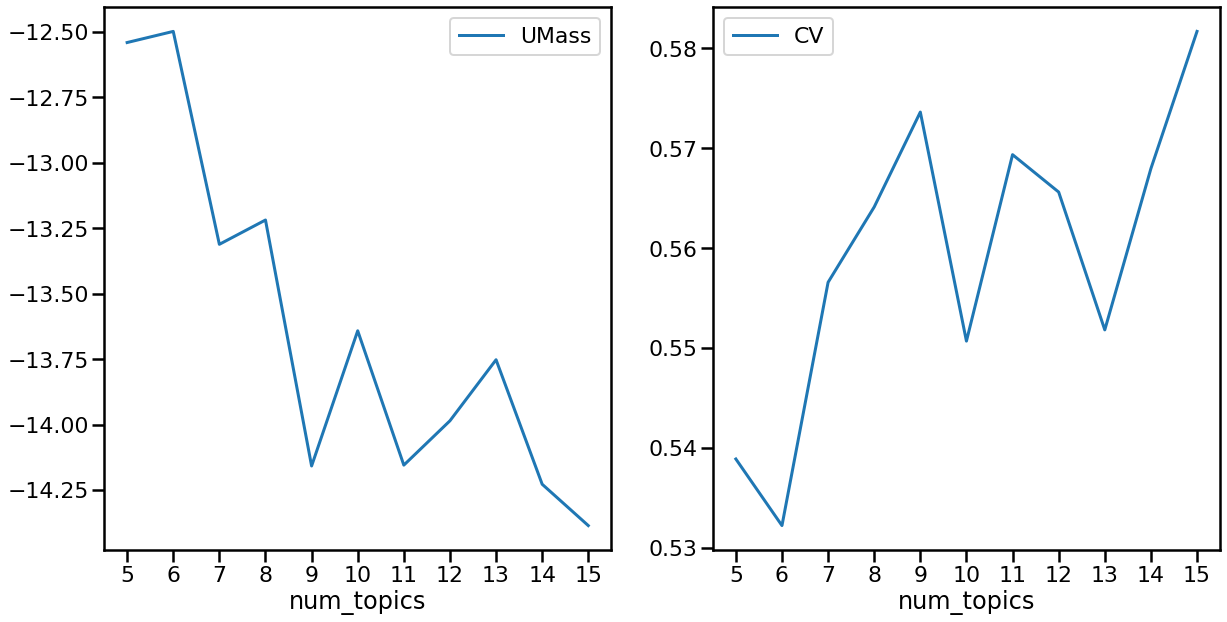

In [47]:
#Plots Umass and Cv scores
%matplotlib inline

sns.set_context('poster') # use large font

scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,16));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,16));

In [48]:
num_topics = 9

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), 
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, # update after this many instances
                     alpha=0.05,  #one dominant topic per doc
                     random_state=42
                    )
    
print("done in {}".format(time.time()-start), flush=True)

712.05
fitting model
done in 11.860045909881592


In [49]:
# Transform the data into topic distros
topic_corpus = model[model_corpus]
# Here we get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# Extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "love", "know", "word", "much", "without"
2 "good", "shall", "first", "power", "well"
3 "eye", "saw", "turn", "mine", "round"
4 "thou", "world", "become", "art", "mind"
5 "make", "doth", "little", "side", "upon"
6 "thus", "light", "far", "great", "speak"
7 "holy", "earth", "circle", "fire", "flame"
8 "begin", "sight", "see", "move", "give"
9 "even", "seem", "one", "say", "soul"


#### IV) Dimensionality Reduction
Now we compare Latent Dicrichlet Allocation with Matrix Factorization.

In [50]:
# Matrix Factorization
documents_Divine_comedy = Divine_comedy['Instances'].to_list() # List of all the instances

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.0001, 
                                   max_df=0.7, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(documents_Divine_comedy)

print(X.shape)

(14241, 5420)


In [51]:
# set number of latent components, same as LDA to compare
k = 9
#SVD
svd = TruncatedSVD(n_components=k)
%time U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

CPU times: user 111 ms, sys: 11.9 ms, total: 123 ms
Wall time: 80.7 ms


In [52]:
#NMF
nmf = NMF(n_components=k, init='nndsvd', random_state=0)

%time W = nmf.fit_transform(X)
H = nmf.components_

CPU times: user 465 ms, sys: 12 ms, total: 477 ms
Wall time: 303 ms


In [53]:
def show_topics(A, vocabulary, topn=5):
    """
    find the top N words for each of the latent dimensions (=rows) in a matrix
    """
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A])
    return [', '.join(t) for t in topic_words]

In [54]:
terms = tfidf_vectorizer.get_feature_names()

In [55]:
# SVD Topics
sorted(show_topics(V, terms))

['come, unto, thee, eye, turn',
 'eye, turn, unto, round, turn round',
 'know, turn, round, good, speak',
 'make, thee, come, great, unto',
 'saw, turn, behold, great, love',
 'say, make, come, unto, master',
 'thee, eye, turn, speak, round',
 'thou, say, thee, make, art',
 'unto, speak, good, near, saw']

In [56]:
# NMF Topics
sorted(show_topics(H, terms))

['come, come unto, time, forth, behold',
 'eye, thine, thine eye, fix, lift',
 'make, great, answer, begin, reply',
 'saw, people, great, light, look',
 'say, master, master say, say thou, say master',
 'thee, tell, shall, speak, know',
 'thou, art, shalt, thou art, hast',
 'turn, round, turn round, love, look',
 'unto, speak, like, near, thy']

#### V) Clustering

In [102]:
# The choice of 2 clusters depends on the fact that we know we are analyzing three poems and Purgatorio and Paradiso are more similar to each other rather than Inferno
#Another explanation could be that it represents the part shared and the part not shared by the poems
# On top of that, both the silhouette analysis and the visualization, suggest this is a good distribution

k = 2

# reduce the dimensionality of the input, to speed up clustering
%time X2 = TruncatedSVD(n_components=300).fit_transform(X) 

agg = AgglomerativeClustering(n_clusters=k)

CPU times: user 2.13 s, sys: 127 ms, total: 2.26 s
Wall time: 1.29 s


In [103]:
sample = np.random.choice(len(X2), replace=False, size=2000)
%time agg_sample_ids = agg.fit_predict(X2[sample])

CPU times: user 754 ms, sys: 8.38 ms, total: 762 ms
Wall time: 777 ms


In [104]:
centroids = np.array([X2[sample][agg_sample_ids == c].mean(axis=0) for c in range(k)])
print(centroids.shape)

(2, 300)


In [105]:
km = KMeans(n_clusters=k, 
            n_jobs=-1, 
            init=centroids)

%time km.fit(X2)

CPU times: user 78.3 ms, sys: 10.8 ms, total: 89.1 ms
Wall time: 66.2 ms


/Users/leonardoyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
<timed eval>:1: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10


KMeans(init=array([[ 2.36427820e-01, -9.76038021e-02, -2.62219263e-02,
        -2.88363382e-02, -3.88081942e-02,  9.70650173e-03,
        -9.23078834e-03, -6.85276338e-03,  3.60768692e-03,
        -2.06660808e-02, -1.21482696e-02,  1.50530295e-03,
         7.11100938e-03, -2.47221018e-03, -4.91043367e-03,
        -2.92465843e-03,  7.12649420e-03,  6.18862722e-03,
         1.92973812e-03,  2.14059350e-03, -4.04898063e-03,
        -5....
         1.11141217e-04, -3.46451804e-04,  8.34940211e-04,
         3.02677019e-04,  3.05734080e-04,  4.14103508e-05,
        -3.89411492e-05,  1.57250129e-04, -1.93800531e-04,
        -1.29582182e-04, -8.09620042e-04,  7.11659433e-04,
        -9.78612507e-04,  8.65889108e-04,  2.99052490e-04,
        -1.47119694e-03,  6.04277637e-04, -4.73547137e-04,
        -5.44626090e-04,  4.29794344e-04,  2.50878342e-04,
         3.16081166e-04,  1.46889716e-04,  1.18055463e-03]]),
       n_clusters=2, n_jobs=-1)

2 0.06535933081394961
3 0.04967625738984933
4 0.051320953359043305
5 0.042653566909987346
6 0.043918973926867104
7 0.027890462397072227
8 0.028724659531254394
9 -0.0009687023751821216
10 0.0017123694711823252
11 0.0044482375428507095
12 0.005958580477432126
13 0.008868648005279702
14 0.011505076327832743


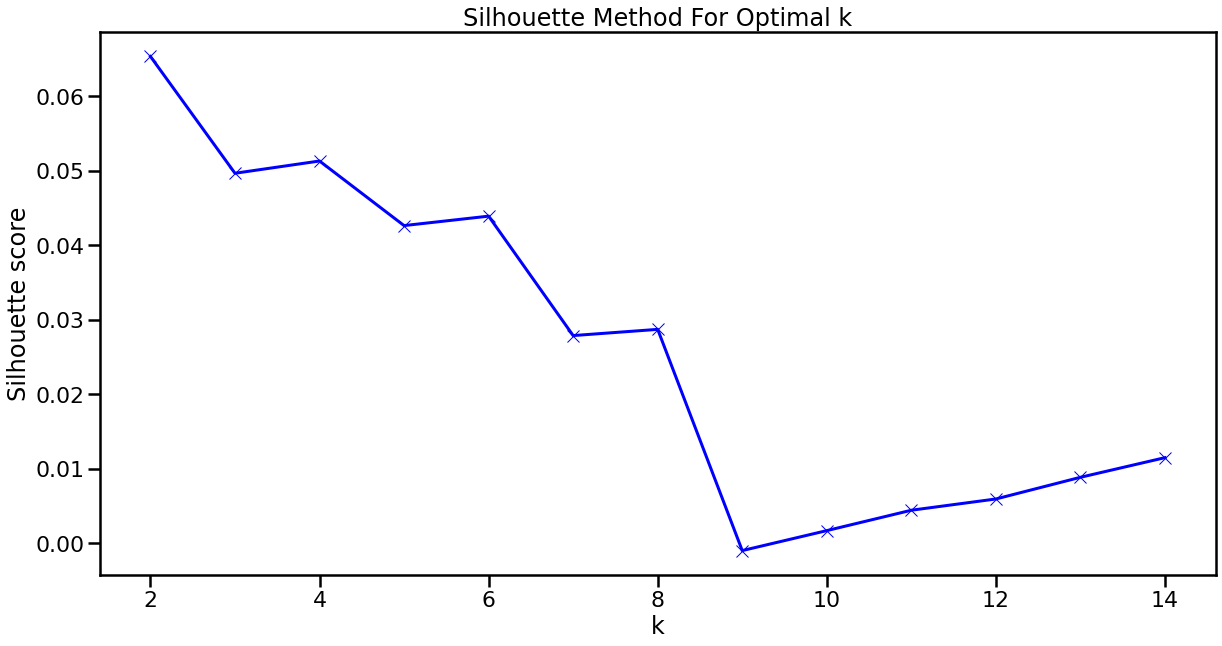

In [106]:
#Silhouette score
silhouettes = []

K = range(2, 15)

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)

    agg_cluster_ids = agg_clustering.fit_predict(X2[sample])

    score = silhouette_score(X2[sample], agg_cluster_ids)
    silhouettes.append(score)
    print(c, score)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

##### VI) Language Model Generation 


In [185]:
#Here we use a Dataset not preprocessed
Div_com = pd.concat([Inferno_before, Purgatorio_before, Paradiso_before], ignore_index=True)

In [188]:
smoothing = 0.001
START = '_***_'
STOP = '_STOP_'

counts = defaultdict(lambda: defaultdict(lambda: smoothing))
corpus = [line.strip().split() for line in Div_com.Text]
for sentence in corpus:
    tokens = [START, START] + sentence + [STOP]
    for u, v, w in nltk.ngrams(tokens, 3):
        counts[(u, v)][w] += 1

In [189]:
def logP(u, v, w):
    return np.log(counts[(u, v)][w]) - np.log(sum(counts[(u, v)].values()))

def sentence_logP(S):
    tokens = [START, START] + S + STOP
    return sum([logP(u, v, w) for u, v, w in nltk.ngrams(tokens, 3)])

def sample_next_word(u, v):
    keys, values = zip(*counts[(u, v)].items())
    values = np.array(values)
    values /= values.sum() # create probability distro
    sample = np.random.multinomial(1, values) # pick one position
    return keys[np.argmax(sample)]

def generate():
    result = [START, START]
    next_word = sample_next_word(result[-2], result[-1])
    result.append(next_word)

    while next_word != STOP:
        next_word = sample_next_word(result[-2], result[-1])
        result.append(next_word)
    return ' '.join(result[2:-1]) 

def generate2(initial=[]):
    result = [START, START] + initial
    next_word = sample_next_word(result[-2], result[-1])
    result.append(next_word)
    while next_word != STOP:
        next_word = sample_next_word(result[-2], result[-1])
        result.append(next_word)

    return ' '.join(result[2:-1])

In [193]:
generate()

'Without a word, and wholly avaricious;'

In [118]:
generate2('He said:'.split())

'He said: "By other ways, by other ports'

#### Extra - NER
Named entity recognition to find most relevant characters in the poem.

##### Inferno

In [125]:
#Rule to recognize Beatrice and Virgilius always as a person (sometimes they were recognized as ORG, maybe due to Non-English name)
nlp = spacy.load("en_core_web_sm")
ruler = nlp.add_pipe("entity_ruler", config={"overwrite_ents": True})
patterns = [{"label": "PERSON", "pattern": "Beatrice"}, {"label": "PERSON", "pattern": "Virgilius"}]
ruler.add_patterns(patterns)

In [126]:
inferno_txt = [line.strip() for line in open('/Users/leonardoyang/Desktop/3060994/inferno_txt/inferno_fin.txt', encoding='utf8').readlines()]

In [127]:
entities= [entity.text for sentence in inferno_txt for entity in nlp(sentence).ents if entity.label_ == "PERSON"]
Counter(entities).most_common(5)

[('Thou', 32), ('Virgilius', 5), ('Began', 5), ('Minos', 4), ('Ye', 4)]

##### Purgatorio

In [128]:
purgatorio_txt = [line.strip() for line in open('/Users/leonardoyang/Desktop/3060994/Purgatorio_txt/Purgatorio_fin.txt', encoding='utf8').readlines()]

In [129]:
entities = [entity.text for sentence in purgatorio_txt for entity in nlp(sentence).ents if entity.label_ == "PERSON"]
Counter(entities).most_common(5)

[('Virgilius', 26), ('Thou', 25), ('Beatrice', 18), ('Began', 10), ('Mary', 6)]

##### Paradiso

In [130]:
paradiso_txt = [line.strip() for line in open('/Users/leonardoyang/Desktop/3060994/paradiso_txt/paradiso_fin.txt', encoding='utf8').readlines()]

In [131]:
entities = [entity.text for sentence in paradiso_txt for entity in nlp(sentence).ents if entity.label_ == "PERSON"]
Counter(entities).most_common(5)

[('Beatrice', 44), ('Thou', 33), ('Mary', 6), ('Began', 5), ("e'er", 3)]

Interesting to notice the transition from Virgilius to Beatrice during Dante's path.

## Visualization


##### Topic Visualization

In [132]:
target_category = 'Text'
# Get a list of all the topic scores for each document
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(Divine_comedy.Text))]
# Turn that into a data frame with N rows and K columns, each with the score of the corresponding topic
topic_distros = pd.DataFrame(data=scores, columns=descriptors)
# Add the review category of each document (so we can aggregate)
topic_distros['category'] = Divine_comedy[target_category]

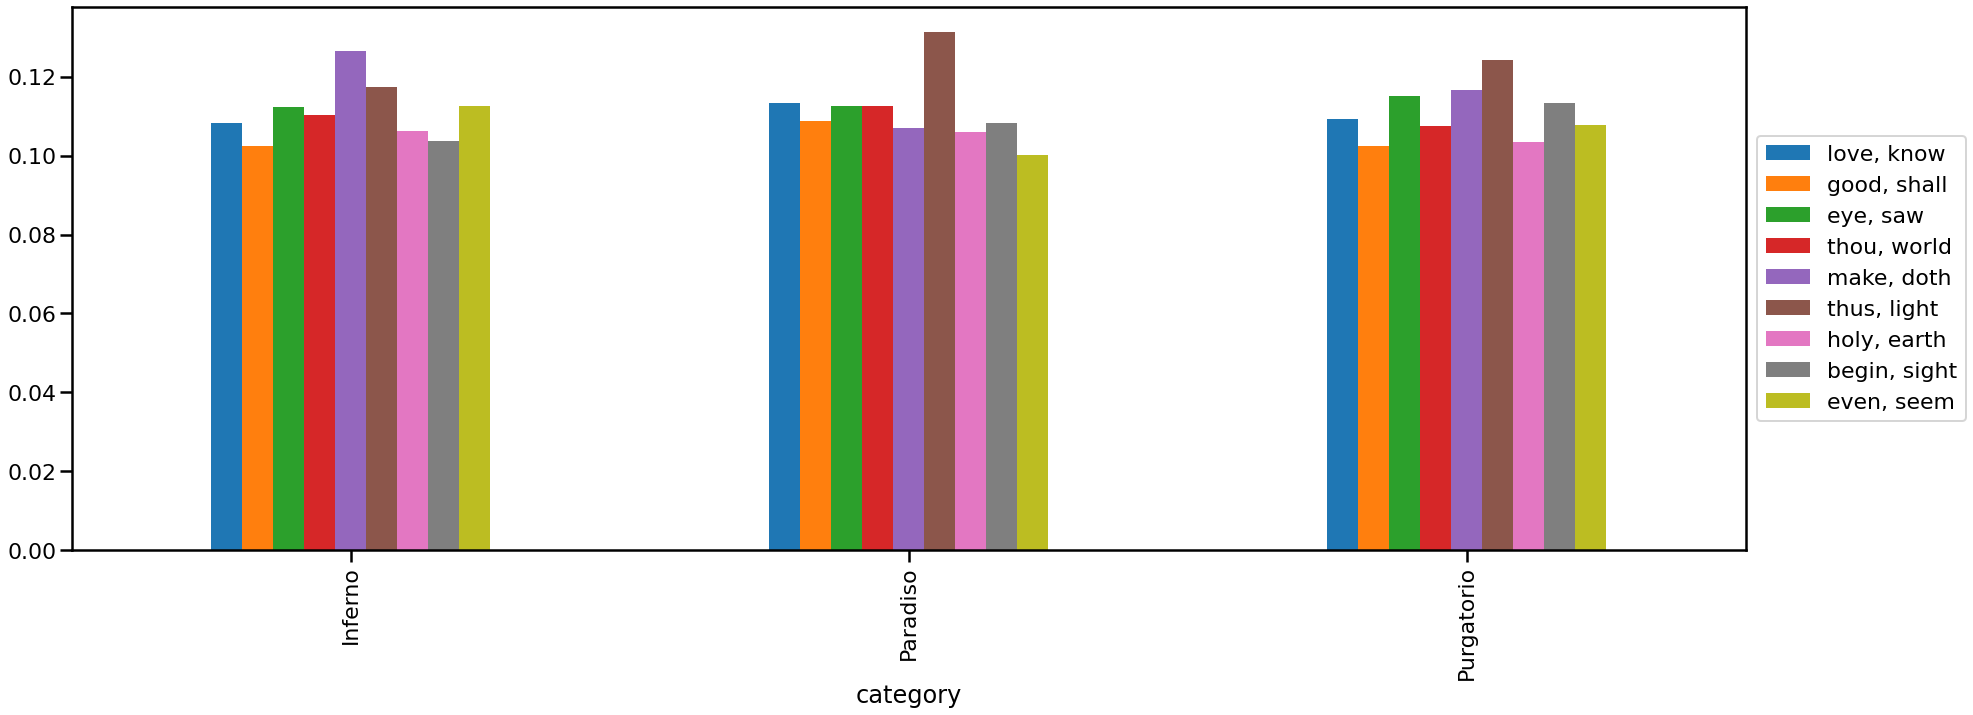

In [133]:
sns.set_context('poster') # use large font

fig, ax = plt.subplots(figsize=(30, 10)) # set graph size
# aggregate topics by categories
aggregate_by_category = topic_distros[topic_distros.category.isin('Inferno Purgatorio Paradiso'.split())]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()
# plot the graph
aggregate_by_category[descriptors].plot.bar(ax=ax);
# move the legend out
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

Topics are overall equally distributed among the poems, except for the one regarding light which is more present in Paradiso, as we expected.

#### TFIDF

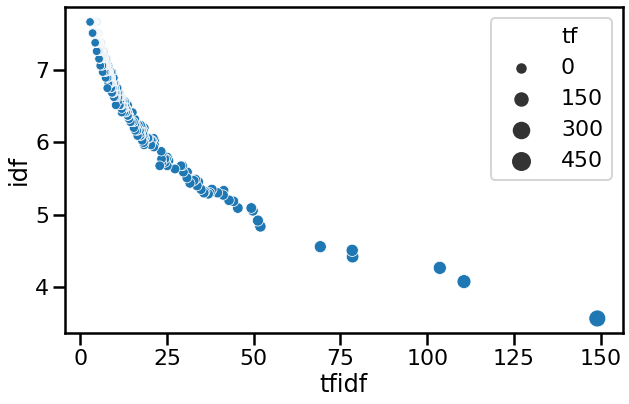

In [134]:
#Inferno
fig, ax = plt.subplots(figsize = (10,6))
sns.scatterplot(data=uni_inf,x="tfidf", y="idf", size="tf")

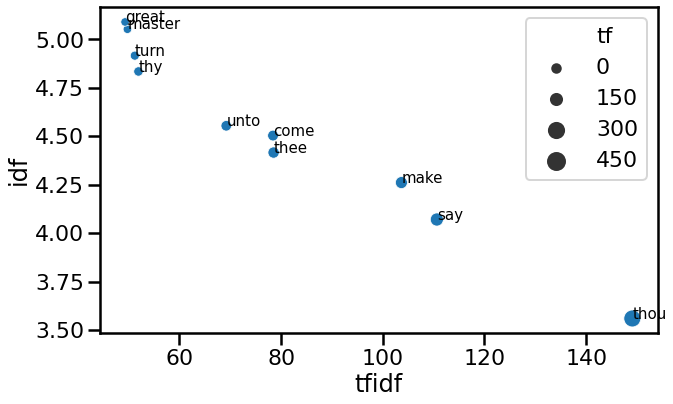

In [135]:
fig, ax = plt.subplots(figsize = (10,6))
sns.scatterplot(data=uni_inf.iloc[:10,:],x="tfidf", y="idf", size="tf")
for label, x, y in zip(uni_inf.iloc[:10,0], uni_inf.iloc[:10,3], uni_inf.iloc[:10,2]):
            txt = plt.annotate(label,xy=(x, y),fontsize=15)

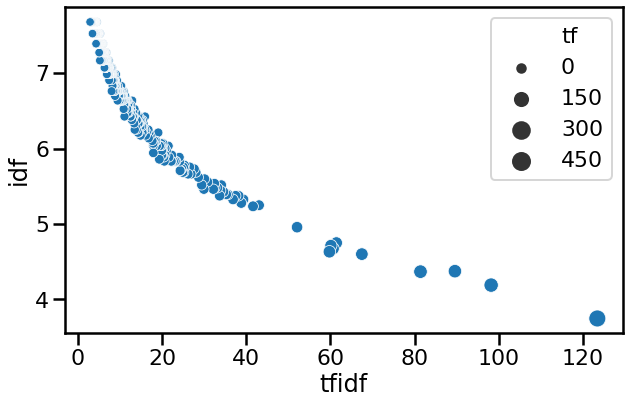

In [136]:
#Purgatorio
fig, ax = plt.subplots(figsize = (10,6))
sns.scatterplot(data=uni_pur,x="tfidf", y="idf", size="tf")

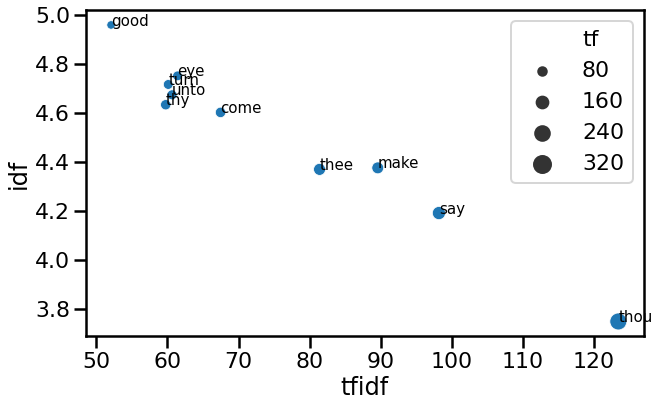

In [137]:
fig, ax = plt.subplots(figsize = (10,6))
sns.scatterplot(data=uni_pur.iloc[:10,:],x="tfidf", y="idf", size="tf")
for label, x, y in zip(uni_pur.iloc[:10,0], uni_pur.iloc[:10,3], uni_pur.iloc[:10,2]):
            txt = plt.annotate(label,xy=(x, y),fontsize=15)

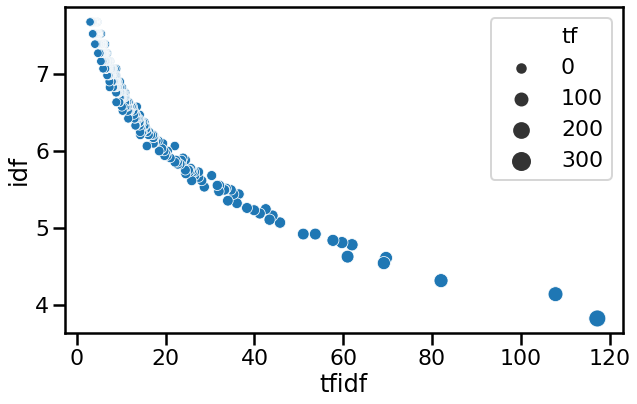

In [138]:
#Paradiso
fig, ax = plt.subplots(figsize = (10,6))
sns.scatterplot(data=uni_par,x="tfidf", y="idf", size="tf")

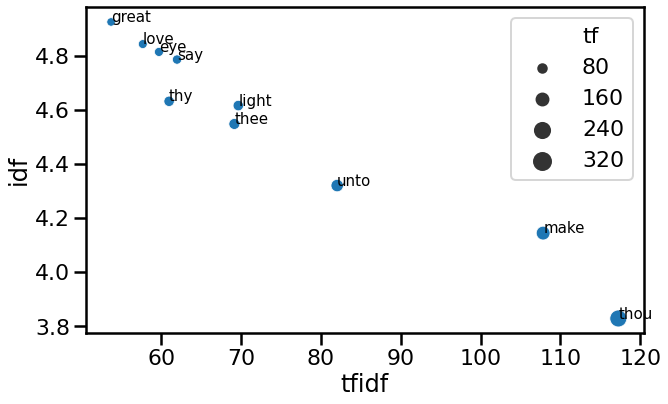

In [139]:
fig, ax = plt.subplots(figsize = (10,6))
sns.scatterplot(data=uni_par.iloc[:10,:],x="tfidf", y="idf", size="tf")
for label, x, y in zip(uni_par.iloc[:10,0], uni_par.iloc[:10,3], uni_par.iloc[:10,2]):
            txt = plt.annotate(label,xy=(x, y),fontsize=15)

##### SVD Visualization

In [140]:
sns.set_context('notebook')

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('tab10') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor=None, 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor=None, 
                       label=label, 
                       alpha=0.4, 
                       s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
    plt.show()

In [141]:
# For the SVD and NMF visualization we need a new randomized DataFrame since we visualize only a part of the data
Divine_comedy_rand = Divine_comedy.sample(frac=1)
documents_rand = Divine_comedy_rand['Instances'].tolist()

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), analyzer='word', min_df=0.001, max_df=0.75, stop_words='english', sublinear_tf=True, use_idf=True)
T = tfidf_vectorizer.fit_transform(documents_rand)
T.shape

(14241, 585)

In [142]:
low_dim_svd = TruncatedSVD(n_components=3) 
categories = Divine_comedy_rand.Text[:2000]
low_dim_U = low_dim_svd.fit_transform(T)

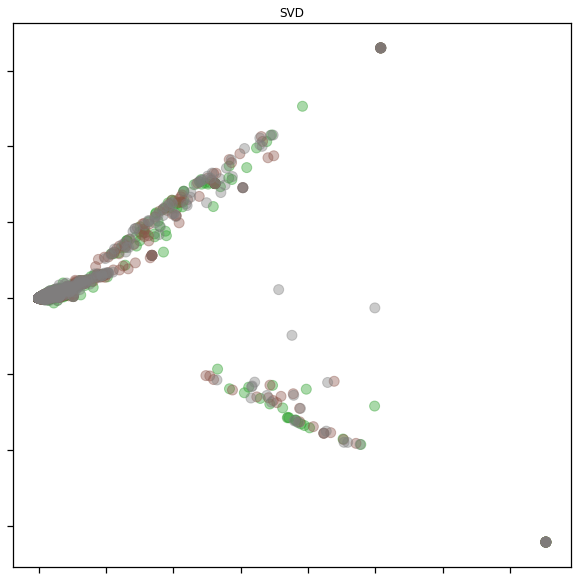

In [143]:
plot_vectors(low_dim_U, title='SVD', labels=categories, dimensions=2)

##### NMF Visualization

In [144]:
low_dim_nmf = NMF(n_components=3, init='nndsvd') 
categories = Divine_comedy_rand.Text[:2000]
low_dim_W = low_dim_nmf.fit_transform(T)

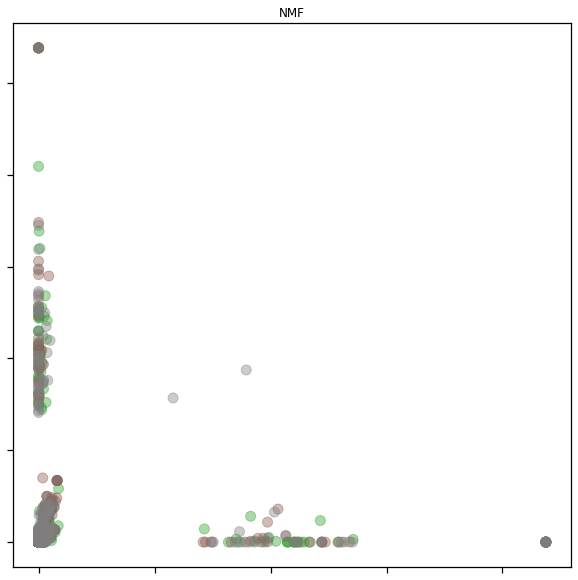

In [145]:
plot_vectors(low_dim_W, title='NMF', labels=categories, dimensions=2)

##### Cluster Visualization

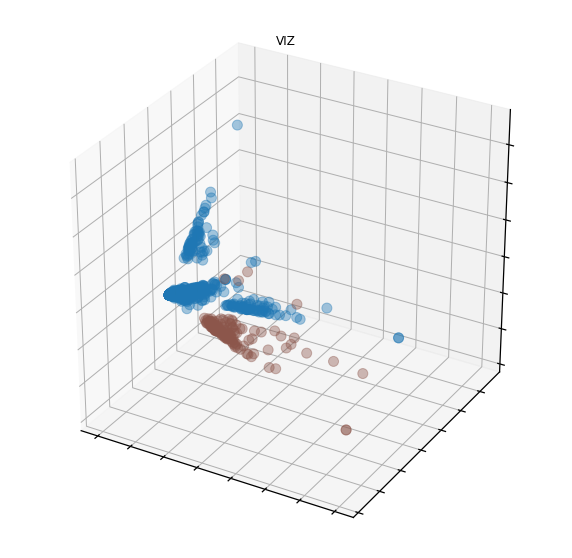

In [146]:
plot_sample = np.random.choice(len(X2), replace=False, size=2000)
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample])

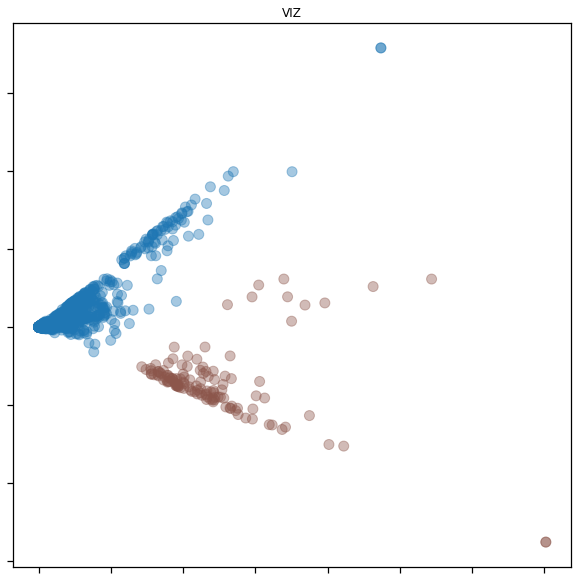

In [147]:
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample], dimensions=2)

##### t-SNE Visualization of the Word2vec

In [148]:
# define the function to compute the dimensionality reduction  
# and then produce the biplot  
def tsne_plot(model):  
    "Creates a TSNE model and plots it"  
    labels = []  
    tokens = []  

    for word in model.wv.vocab:  
        tokens.append(model[word])  
        labels.append(word)  

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500)  
    new_values = tsne_model.fit_transform(tokens)  

    x = []  
    y = []  
    for value in new_values:  
        x.append(value[0])  
        y.append(value[1])  

    plt.figure(figsize=(20, 20))   
    for i in range(len(x)):  
        plt.scatter(x[i],y[i])  
        plt.annotate(labels[i],  
        xy=(x[i], y[i]),  
        xytext=(5, 2),  
        textcoords='offset points',  
        ha='right',  
        va='bottom')  
    plt.show()

<ipython-input-148-a8d44e0bfc1a>:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model[word])


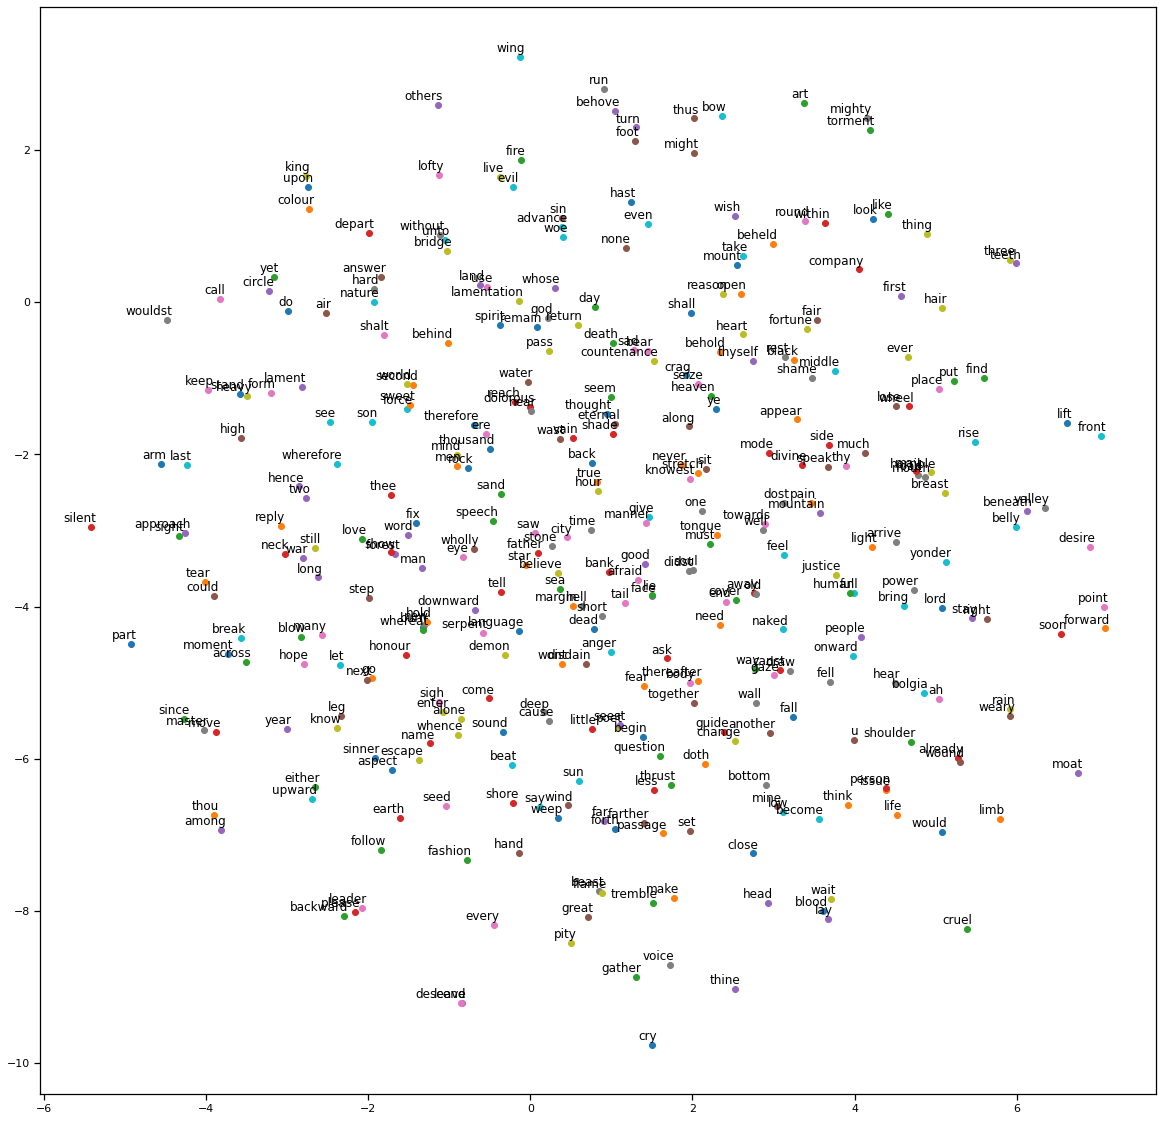

In [149]:
tsne_plot(w2v_model_inf)

<ipython-input-148-a8d44e0bfc1a>:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model[word])


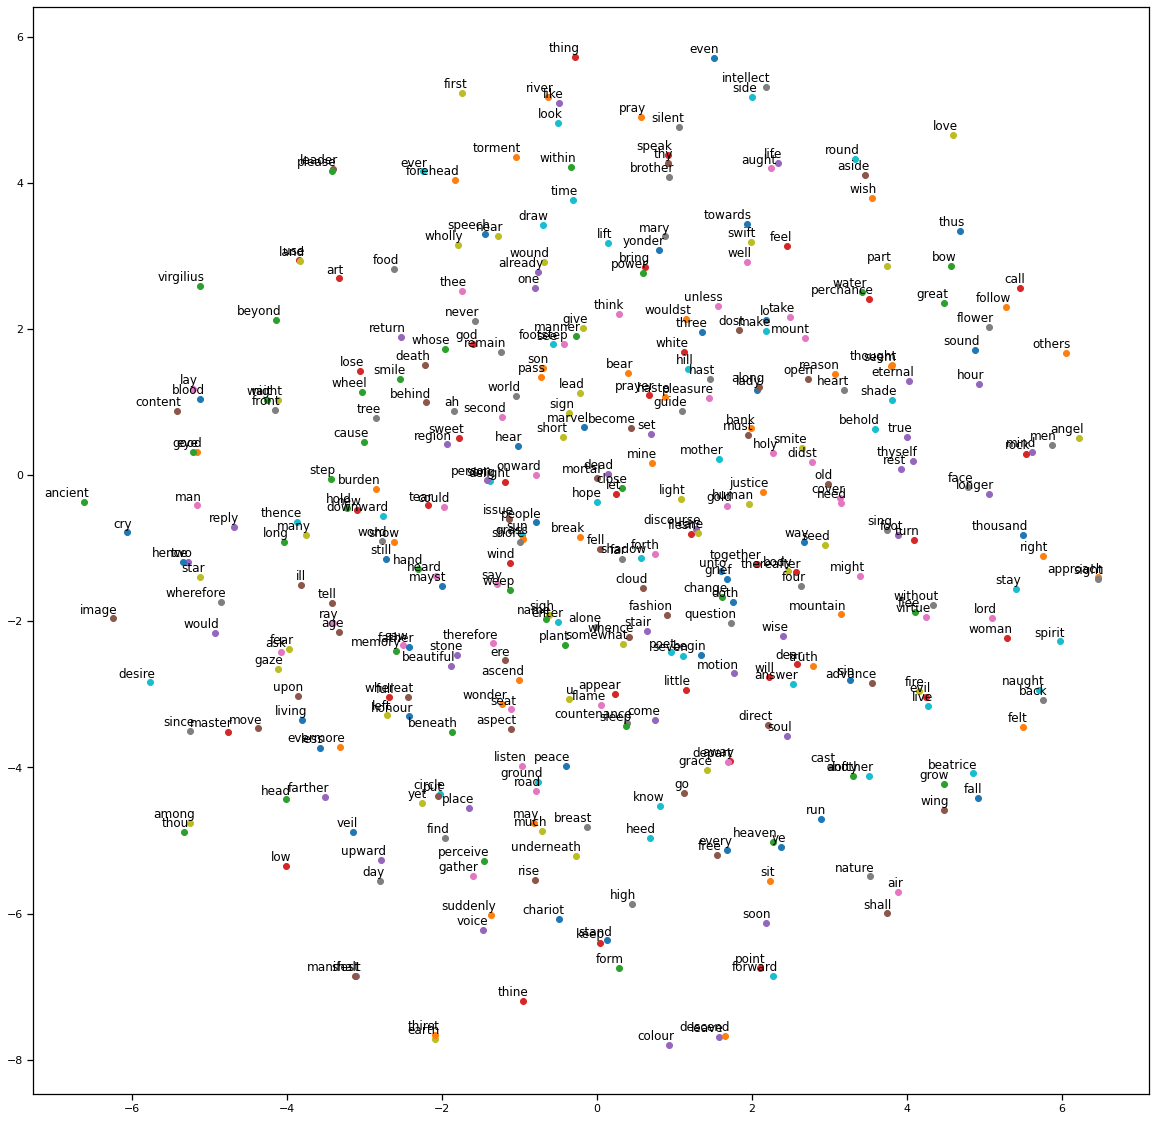

In [150]:
tsne_plot(w2v_model_pur)

<ipython-input-148-a8d44e0bfc1a>:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model[word])


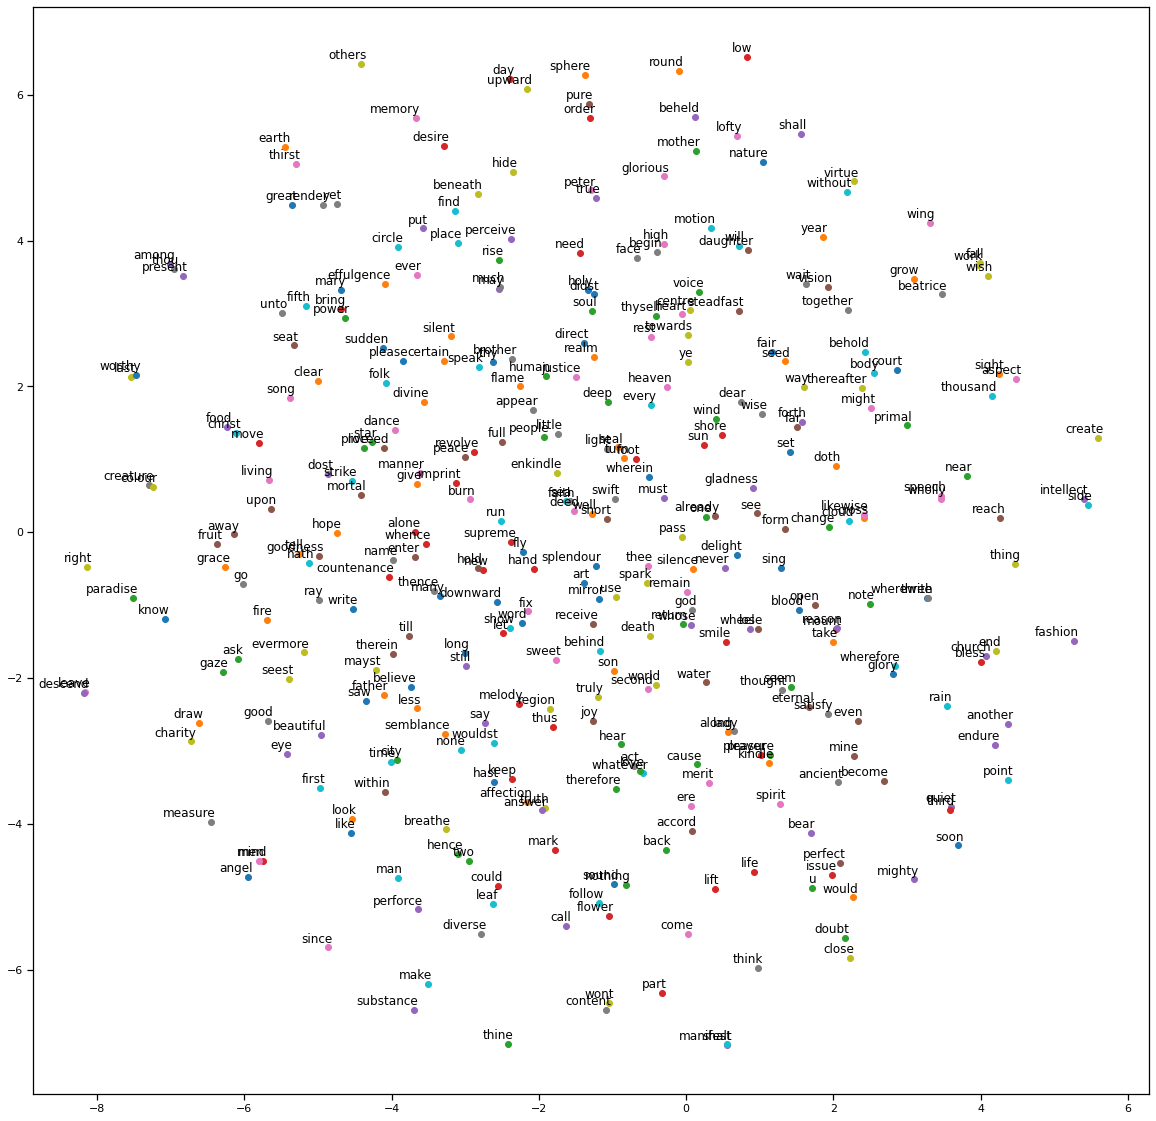

In [151]:
tsne_plot(w2v_model_par)

#### Extra
Since we are analyzing a poem, could be significant to analyze the text also by tercets, even though we do not reach the minimum lenght required.
We do not find significant differences in the first part of the analysis regarding Word embeddings, Tfidf, thus here we provide only results of the topic distribution.

In [152]:
#Divide Inferno into tercets
Inferno_terzine = Inferno.groupby(Inferno.index // 3).agg(''.join)
Inferno_terzine['Tokens'] = Inferno_terzine['Instances'] 
Inferno_terzine['Tokens'] = [word_tokenize(entry) for entry in Inferno_terzine['Instances']]
Inferno_terzine['Text'] = 'Inferno'
Inferno_terzine = Inferno_terzine[['Text', 'Tokens', 'Instances']] 

In [153]:
Inferno_terzine.tail()

,Text,Tokens,Instances
1569,Inferno,"[place, beelzebubfar, recede, tomb, extendsigh...",place beelzebubfar recede tomb extendsight kno...
1570,Inferno,"[small, rivulet, descendethchasm, within, ston...",small rivulet descendethchasm within stone gna...
1571,Inferno,"[guide, hidden, roadenter, return, bright, wor...",guide hidden roadenter return bright worldwith...
1572,Inferno,"[mount, first, secondtill, behold, round, aper...",mount first secondtill behold round aperturebe...
1573,Inferno,"[thence, come, forth, rebehold, star]",thence come forth rebehold star


In [154]:
#Divide Purgatorio into tercets
Purgatorio_terzine = Purgatorio.groupby(Purgatorio.index // 3).agg(''.join)
Purgatorio_terzine['Tokens'] = Purgatorio_terzine['Instances'] 
Purgatorio_terzine['Tokens'] = [word_tokenize(entry) for entry in Purgatorio_terzine['Instances']]
Purgatorio_terzine['Text'] = 'Purgatorio'
Purgatorio_terzine = Purgatorio_terzine[['Text', 'Tokens', 'Instances']] 

In [155]:
#Divide Paradiso into tercets
Paradiso_terzine = Paradiso.groupby(Paradiso.index // 3).agg(''.join)
Paradiso_terzine['Tokens'] = Paradiso_terzine['Instances'] 
Paradiso_terzine['Tokens'] = [word_tokenize(entry) for entry in Paradiso_terzine['Instances']]
Paradiso_terzine['Text'] = 'Paradiso'
Paradiso_terzine = Paradiso_terzine[['Text', 'Tokens', 'Instances']] 

In [156]:
Divine_comedy_ter = pd.concat([Inferno_terzine, Purgatorio_terzine, Paradiso_terzine], ignore_index=True)

In [157]:
Divine_comedy_ter.tail()

,Text,Tokens,Instances
4743,Paradiso,"[seem, paint, effigywherefore, sight, absorbed...",seem paint effigywherefore sight absorbed ther...
4744,Paradiso,"[square, circle, discoverstake, thought, princ...",square circle discoverstake thought principle ...
4745,Paradiso,"[wish, see, image, circleconform, find, placew...",wish see image circleconform find placewing en...
4746,Paradiso,"[mind, smiteflash, lightning, wherein, come, w...",mind smiteflash lightning wherein come wishvig...
4747,Paradiso,"[turn, desireeven, wheel, equally, movelove, m...",turn desireeven wheel equally movelove move su...


##### Topic model

In [158]:
# We run on all instances, already preprocessed before
instances = Divine_comedy_ter.Tokens
# Read in instances and create Dictionary object w information about frequencies etc. 
dictionary = Dictionary(instances)
# Get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=20, no_above=0.3)
print(dictionary, flush=True)

Dictionary(301 unique tokens: ['lose', 'upon', 'within', 'fear', 'thing']...)


In [159]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In [160]:
#Find the right number of topics with Coherence Model on a subset of the data.

coherence_values = []

dev_size = 2000

# The number more satisfying, in particular for the cv score, was 11. In the light of this information, we will show just the range(5, 16)

for num_topics in range(5, 16):
    model = LdaMulticore(corpus=model_corpus[:dev_size], 
                         id2word=dictionary, 
                         num_topics=num_topics,random_state=42 ) 

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances[:dev_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances[:dev_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

5 -7.125687494408952 0.33570499958354494
6 -7.187301886702599 0.31810505814578044
7 -7.896457098479288 0.3312504562596059
8 -7.897386752513935 0.3358915106206777
9 -8.333800311000683 0.34359246864923354
10 -8.100144282625298 0.35032108567854814
11 -9.08139603054555 0.3837766690187621
12 -8.397124639273773 0.3470825856799957
13 -8.816324181117198 0.36231954278063416
14 -8.774369526460145 0.36942915181570396
15 -9.419957457952153 0.382502291400796


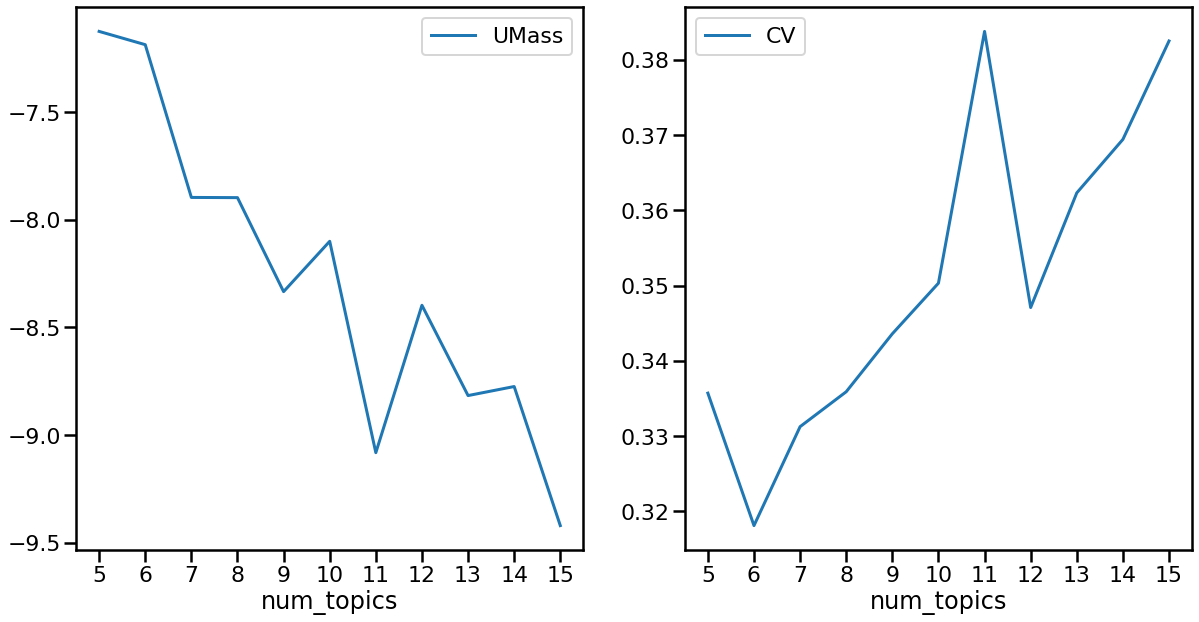

In [161]:
%matplotlib inline

sns.set_context('poster') # use large font


scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,16));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,16));

In [162]:
num_topics = 11

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, # update after this many instances
                     alpha=0.1,     #one dominant topic per doc
                     random_state=42
                    )
    
print("done in {}".format(time.time()-start), flush=True)

237.4
fitting model
done in 5.5504469871521


In [163]:
# Transform the data into topic distros
topic_corpus = model[model_corpus]
# Here we get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# Extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "holy", "sight", "truth", "doth", "keep"
2 "thou", "thy", "thee", "mind", "hast"
3 "sun", "already", "good", "name", "heart"
4 "light", "great", "together", "wing", "whose"
5 "mine", "god", "eye", "upon", "earth"
6 "even", "grace", "love", "many", "first"
7 "desire", "within", "vision", "begin", "remain"
8 "shall", "world", "living", "way", "speak"
9 "thing", "two", "high", "hold", "foot"
10 "every", "shalt", "thou", "make", "others"
11 "would", "well", "son", "soul", "behind"


In [164]:
target_category = 'Text'
# Get a list of all the topic scores for each document
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(Divine_comedy_ter.Text))]
# Turn that into a data frame with N rows and K columns, each with the score of the corresponding topic
topic_distros = pd.DataFrame(data=scores, columns=descriptors)
# Add the review category of each document (so we can aggregate)
topic_distros['category'] = Divine_comedy_ter[target_category]

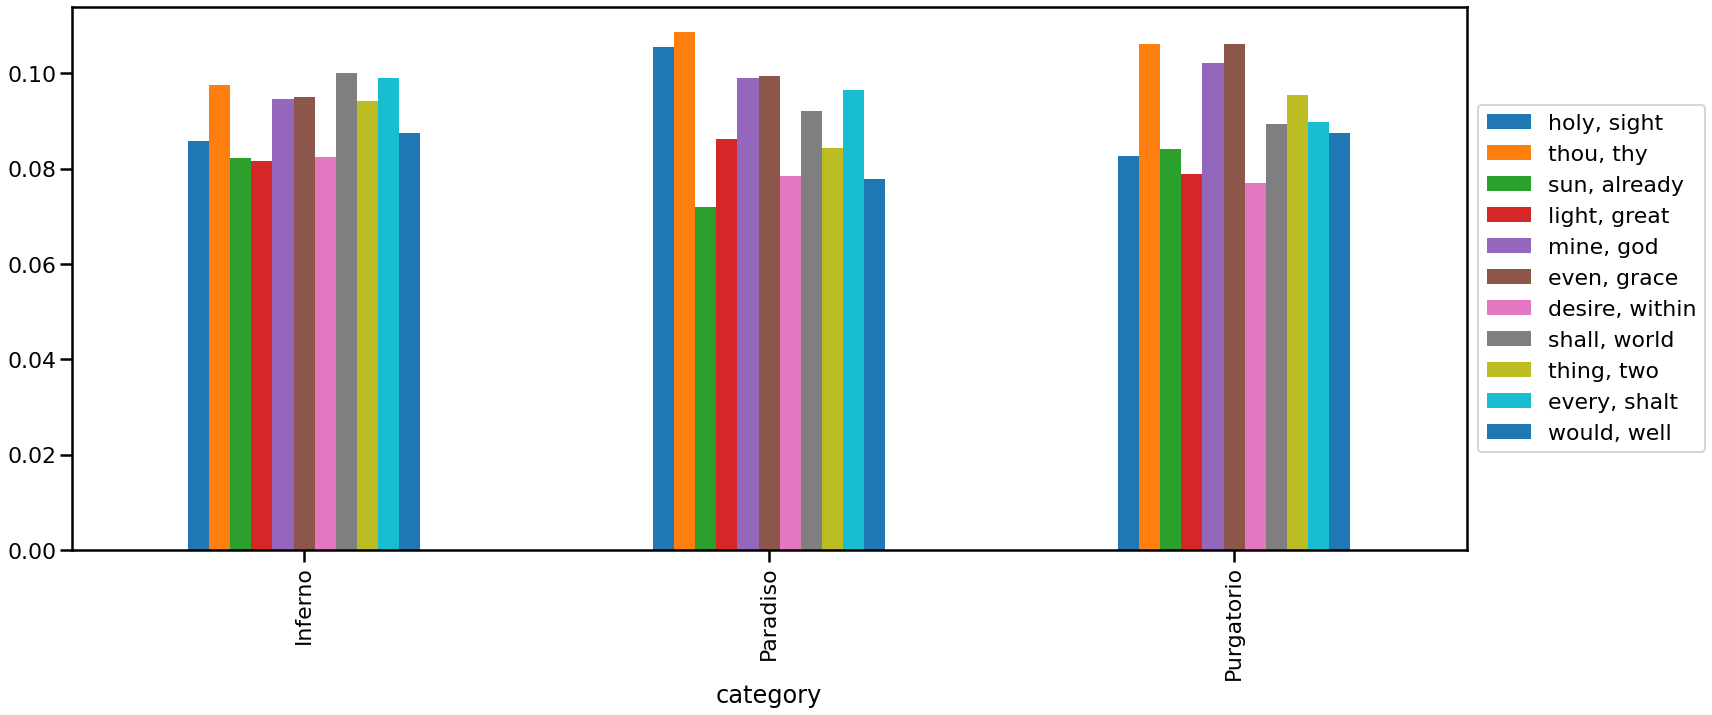

In [165]:
sns.set_context('poster') # use large font

fig, ax = plt.subplots(figsize=(25, 10)) # set graph size
# aggregate topics by categories
aggregate_by_category = topic_distros[topic_distros.category.isin('Inferno Purgatorio Paradiso'.split())]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()
# plot the graph
aggregate_by_category[descriptors].plot.bar(ax=ax);
# move the legend out
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

Dividing the poems in tercets, we can notice a more heterogeneous distribution of the topics among the poems. 

#### Dimensionality Reduction

In [166]:
# Matrix Factorization
documents_Divine_comedy_ter = Divine_comedy_ter['Instances'].to_list() # List of all the instances

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(documents_Divine_comedy_ter)

print(X.shape)

(4748, 1151)


In [167]:
# set number of latent components
k = 11
#SVD
svd = TruncatedSVD(n_components=k)
%time U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

CPU times: user 25.3 ms, sys: 3.87 ms, total: 29.1 ms
Wall time: 23.6 ms


In [168]:
#NMF
nmf = NMF(n_components=k, init='nndsvd', random_state=0)

%time W = nmf.fit_transform(X)
H = nmf.components_

CPU times: user 195 ms, sys: 5.42 ms, total: 201 ms
Wall time: 207 ms


In [169]:
def show_topics(A, vocabulary, topn=5):
    """
    find the top N words for each of the latent dimensions (=rows) in a matrix
    """
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A])
    return [', '.join(t) for t in topic_words]

In [170]:
terms = tfidf_vectorizer.get_feature_names()

In [171]:
# SVD Topics
sorted(show_topics(V, terms))

['come, turn, shall, time, round',
 'doth, turn, know, good, love',
 'great, doth, time, far, thee',
 'make, thou, art, know, hast',
 'make, unto, eye, come, great',
 'say, make, master, say thou, master say',
 'thee, thy, say, life, tell',
 'thou, make, thee, say, thy',
 'thy, doth, come, shall, mind',
 'thy, turn, round, great, turn round',
 'unto, say, thou, make, like unto']

In [172]:
# NMF Topics
sorted(show_topics(H, terms))

['come, shall, forth, time, appear',
 'doth, love, good, thing, nature',
 'eye, saw, thine, thine eye, light',
 'great, time, far, saw, speak',
 'make, know, appear, good, god',
 'say, master, say thou, master say, wish',
 'thee, heaven, life, love, tell',
 'thou, art, hast, dost, shalt',
 'thy, mind, thy mind, shall, good',
 'turn, round, turn round, love, high',
 'unto, like, face, like unto, speak']

In [173]:
# For the SVD and NMF visualization we need a new randomized DataFrame since we visualize only a part of the data
Divine_comedy_rand_ter = Divine_comedy_ter.sample(frac=1)
documents_rand = Divine_comedy_rand_ter['Instances'].tolist()

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), analyzer='word', min_df=0.001, max_df=0.75, stop_words='english', sublinear_tf=True, use_idf=True)
T = tfidf_vectorizer.fit_transform(documents_rand)
T.shape

(4748, 1151)

In [174]:
low_dim_svd = TruncatedSVD(n_components=3)
categories = Divine_comedy_rand_ter.Text[:2000]
low_dim_U = low_dim_svd.fit_transform(T)

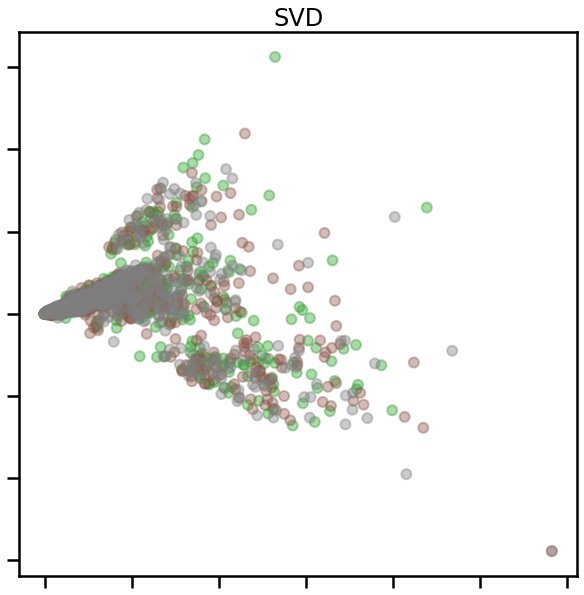

In [175]:
plot_vectors(low_dim_U, title='SVD', labels=categories, dimensions=2)

In [176]:
low_dim_nmf = NMF(n_components=3, init='nndsvd')
categories = Divine_comedy_rand_ter.Text[:2000]
low_dim_W = low_dim_nmf.fit_transform(T)

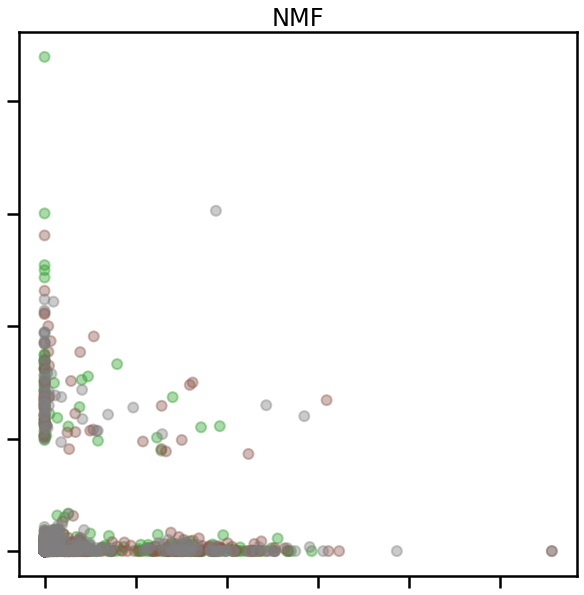

In [177]:
plot_vectors(low_dim_W, title='NMF', labels=categories, dimensions=2)

#### Clustering

In [178]:
# The choice of 2 clusters depends on the fact that we know we are analyzing three poems and Purgatorio and Paradiso are more close to each other rather than Inferno
#Another explanation could be that it represents the part shared and the part not shared by the poems
# On top of that, both the silhouette analysis and the visualization, suggest this is a good distribution

k = 2

# reduce the dimensionality of the input, to speed up clustering
%time X2 = TruncatedSVD(n_components=300).fit_transform(X)

agg = AgglomerativeClustering(n_clusters=k)

CPU times: user 763 ms, sys: 60.8 ms, total: 824 ms
Wall time: 494 ms


In [179]:
sample = np.random.choice(len(X2), replace=False, size=2000)
%time agg_sample_ids = agg.fit_predict(X2[sample])

CPU times: user 828 ms, sys: 18.7 ms, total: 846 ms
Wall time: 764 ms


In [180]:
centroids = np.array([X2[sample][agg_sample_ids == c].mean(axis=0) for c in range(k)])
print(centroids.shape)

(2, 300)


In [181]:
km = KMeans(n_clusters=k, 
            n_jobs=-1, 
            init=centroids)

# fit it on the full 300-dimensional data set
%time km.fit(X2)

CPU times: user 30.2 ms, sys: 5.57 ms, total: 35.8 ms
Wall time: 25.3 ms


/Users/leonardoyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
<timed eval>:1: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10


KMeans(init=array([[ 7.74470888e-02,  3.43323873e-02, -1.99777348e-02,
        -1.04156626e-02, -1.19047422e-02, -6.69499834e-03,
         8.96956304e-03,  4.13870992e-03,  6.57633279e-03,
         4.55905538e-03, -1.31637750e-03,  6.83087109e-03,
        -1.91498467e-03, -2.25910801e-03,  3.91608066e-03,
         4.06661007e-03, -4.92173724e-03,  5.41682479e-03,
         1.04825623e-03,  2.22511582e-03,  5.42954203e-03,
        -6.2191...
        -5.54472649e-04,  8.94964953e-04,  8.00242075e-04,
        -1.80613346e-03, -6.05785923e-04,  5.55471503e-04,
        -4.03365212e-03,  5.74202392e-03,  1.60528461e-03,
        -7.20150943e-03,  3.02589628e-03, -5.25667096e-05,
         1.96633972e-03, -1.14651891e-03, -3.52531084e-03,
        -5.05520664e-03,  3.60881563e-03, -8.86937689e-04,
        -1.10139969e-03, -3.65020633e-03,  8.03600037e-04]]),
       n_clusters=2, n_jobs=-1)

2 0.03120161764574452
3 0.030754850650507863
4 -0.0010132416166593386
5 -0.00014703500109337098
6 0.0002847458474432841
7 0.0020616295434131094
8 0.0030104040556752985
9 0.004441669834515828
10 0.005516525344909052
11 0.00593752611039204
12 0.005073784725594146
13 0.006012629606992875
14 0.004563239965412644


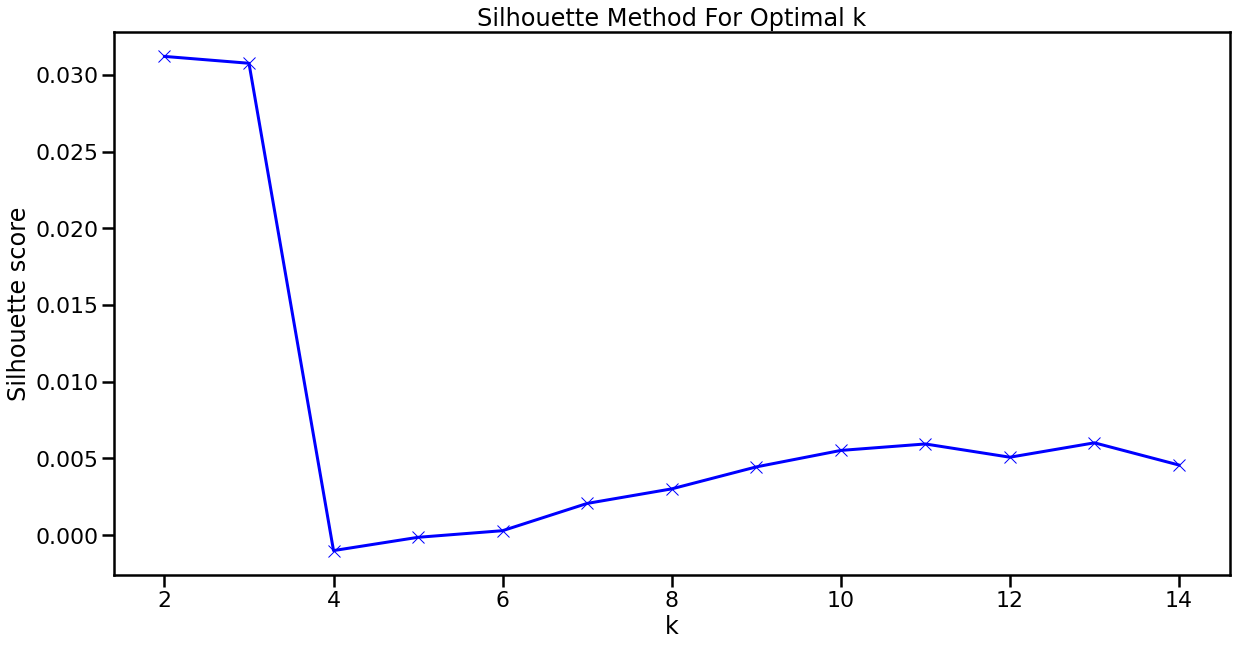

In [182]:
silhouettes = []

K = range(2, 15)

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)

    agg_cluster_ids = agg_clustering.fit_predict(X2[sample])

    score = silhouette_score(X2[sample], agg_cluster_ids)
    silhouettes.append(score)
    print(c, score)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

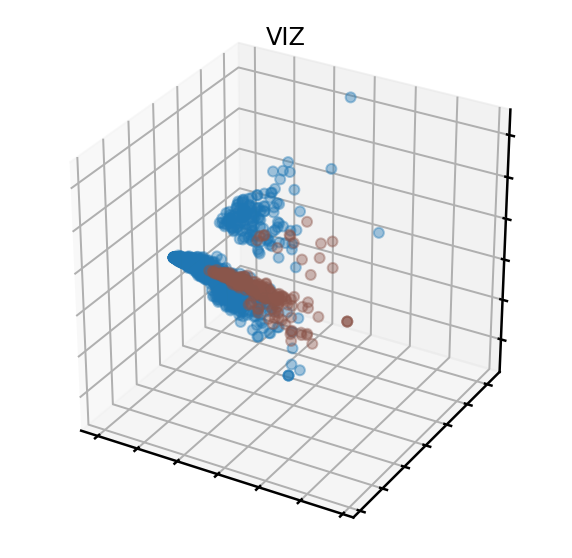

In [183]:
plot_sample = np.random.choice(len(X2), replace=False, size=2000)
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample])

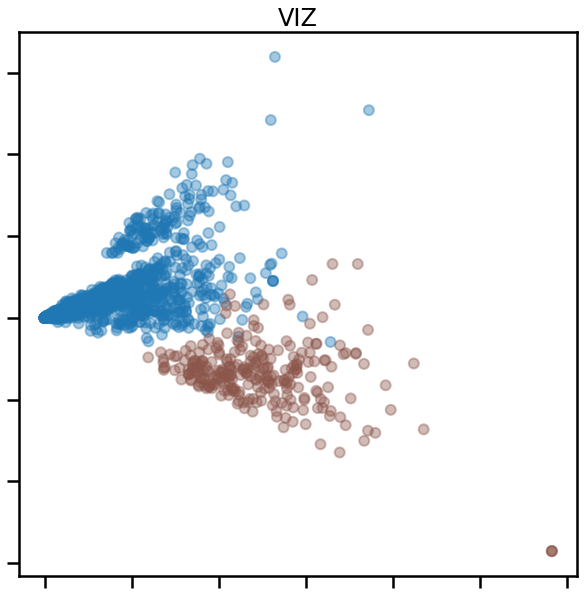

In [184]:
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample], dimensions=2)